# 10.1d: Hypercube Extent Profile

**Visualize the crystal's extent in each dimension (gamma units with ε reference)**

## The Question

We know the crystal is a sparse 2,181-dimensional hypercube, but what does it actually look like?

For each dimension:
- How wide is it in **gamma units** (the actual physical scale)?
- How does that compare to **ε** (the bfloat16 quantum)?

## Approach

**Primary metric:** Range in gamma units (float32 values)
- This is the real physical extent
- Units: dimensionless (hidden space natural units)

**Reference scale:** ε ≈ 3.05×10⁻⁵
- Mark ε, 2ε, 3ε on plots as gridlines
- Shows relationship to bfloat16 precision

**Visualizations:**
1. Sorted extent profile (smallest to largest)
2. Distribution histogram with ε markers
3. 2D scatter: dimension index vs extent
4. Breakdown by width category (0ε, 1ε, 2ε)

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"

# Input files
CLUSTER_FILE = "dense_cluster.safetensors"
CLUSTER_VECTORS_KEY = "vectors"

LATTICE_BASIS_FILE = "lattice_basis.safetensors"

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports loaded")

✓ Imports loaded


## Load Data

In [3]:
data_dir = Path(TENSOR_DIR)

print("Loading crystal vectors...")
cluster_data = load_file(data_dir / CLUSTER_FILE)
vectors = cluster_data[CLUSTER_VECTORS_KEY]

n_vectors = len(vectors)
d = vectors.shape[1]

print(f"  Crystal size: {n_vectors:,} vectors")
print(f"  Dimensions:   {d:,}")
print()

print("Loading lattice basis info...")
basis_data = load_file(data_dir / LATTICE_BASIS_FILE)
dim_range = basis_data["dim_range"]
dim_n_unique = basis_data["dim_n_unique"]
is_frozen = basis_data["is_frozen"]
is_active = ~is_frozen

print(f"  Active dimensions: {is_active.sum().item():,}")
print(f"  Frozen dimensions: {is_frozen.sum().item():,}")
print()

print("✓ Data loaded")

Loading crystal vectors...
  Crystal size: 124 vectors
  Dimensions:   2,560

Loading lattice basis info...
  Active dimensions: 2,181
  Frozen dimensions: 379

✓ Data loaded


## Compute ε

In [4]:
def bfloat16_ulp(x):
    """Compute bfloat16 ULP at scale of x."""
    x = abs(x)
    if x == 0:
        return 2.0 ** (-133)
    exponent = int(np.floor(np.log2(x)))
    return 2.0 ** (exponent - 7)

# Global epsilon
typical_magnitude = vectors.abs().mean().item()
ulp = bfloat16_ulp(typical_magnitude)
epsilon = 2.0 * ulp

print(f"Reference scale:")
print(f"  ε (2×ULP): {epsilon:.6e} gamma units")
print()

print("✓ ε computed")

Reference scale:
  ε (2×ULP): 3.051758e-05 gamma units

✓ ε computed


## Extent Statistics

In [5]:
print("Extent statistics (gamma units):\n")

print(f"All {d:,} dimensions:")
print(f"  Min range:    {dim_range.min().item():.6e}")
print(f"  Max range:    {dim_range.max().item():.6e}")
print(f"  Mean range:   {dim_range.mean().item():.6e}")
print(f"  Median range: {dim_range.median().item():.6e}")
print()

print(f"Active dimensions only ({is_active.sum().item():,}):")
active_ranges = dim_range[is_active]
print(f"  Min range:    {active_ranges.min().item():.6e}")
print(f"  Max range:    {active_ranges.max().item():.6e}")
print(f"  Mean range:   {active_ranges.mean().item():.6e}")
print(f"  Median range: {active_ranges.median().item():.6e}")
print()

print(f"In units of ε:")
print(f"  Min range:    {active_ranges.min().item() / epsilon:.2f}ε")
print(f"  Max range:    {active_ranges.max().item() / epsilon:.2f}ε")
print(f"  Mean range:   {active_ranges.mean().item() / epsilon:.2f}ε")
print(f"  Median range: {active_ranges.median().item() / epsilon:.2f}ε")
print()

print("✓ Statistics computed")

Extent statistics (gamma units):

All 2,560 dimensions:
  Min range:    0.000000e+00
  Max range:    6.103539e-05
  Mean range:   3.688635e-05
  Median range: 3.814697e-05

Active dimensions only (2,181):
  Min range:    1.525879e-05
  Max range:    6.103539e-05
  Mean range:   4.329622e-05
  Median range: 4.005432e-05

In units of ε:
  Min range:    0.50ε
  Max range:    2.00ε
  Mean range:   1.42ε
  Median range: 1.31ε

✓ Statistics computed


## Breakdown by Width Category

In [6]:
print("Categorizing dimensions by extent...\n")

# Define categories based on ε
FROZEN_THRESHOLD = 1e-10  # Essentially zero

# Categorize
n_frozen = is_frozen.sum().item()
n_near_epsilon = ((dim_range >= 0.5 * epsilon) & (dim_range < 1.5 * epsilon)).sum().item()
n_near_2epsilon = ((dim_range >= 1.5 * epsilon) & (dim_range < 2.5 * epsilon)).sum().item()
n_larger = (dim_range >= 2.5 * epsilon).sum().item()

print("Dimension categories (by extent in gamma units):")
print()
print(f"  Frozen (≈0):        {n_frozen:,} ({100 * n_frozen / d:.1f}%)")
print(f"  Near 1ε:            {n_near_epsilon:,} ({100 * n_near_epsilon / d:.1f}%)")
print(f"  Near 2ε:            {n_near_2epsilon:,} ({100 * n_near_2epsilon / d:.1f}%)")
print(f"  Larger (> 2.5ε):    {n_larger:,} ({100 * n_larger / d:.1f}%)")
print()

print("✓ Categorization complete")

Categorizing dimensions by extent...

Dimension categories (by extent in gamma units):

  Frozen (≈0):        379 (14.8%)
  Near 1ε:            1,216 (47.5%)
  Near 2ε:            965 (37.7%)
  Larger (> 2.5ε):    0 (0.0%)

✓ Categorization complete


## Visualization 1: Sorted Extent Profile

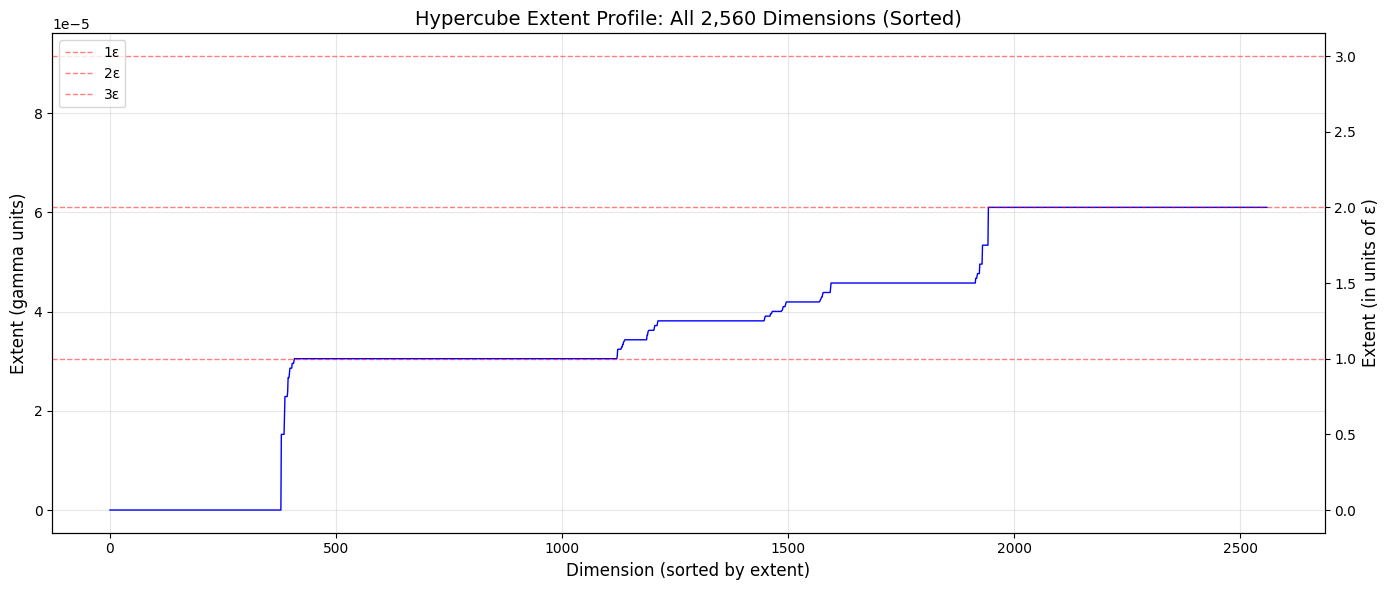

✓ Sorted profile plotted


In [7]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)

# Sort dimensions by range
ranges_sorted = torch.sort(dim_range)[0]
ranges_sorted_np = ranges_sorted.cpu().numpy()

# Plot
ax.plot(range(len(ranges_sorted_np)), ranges_sorted_np, linewidth=1, color='blue')

# Mark ε gridlines
for i in range(1, 4):
    ax.axhline(i * epsilon, color='red', linestyle='--', linewidth=1, alpha=0.5,
               label=f'{i}ε' if i == 1 else f'{i}ε')

ax.set_xlabel('Dimension (sorted by extent)', fontsize=12)
ax.set_ylabel('Extent (gamma units)', fontsize=12)
ax.set_title(f'Hypercube Extent Profile: All {d:,} Dimensions (Sorted)', fontsize=14)
ax.legend(fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3)

# Add secondary y-axis in units of ε
ax2 = ax.twinx()
ax2.set_ylim([y / epsilon for y in ax.get_ylim()])
ax2.set_ylabel('Extent (in units of ε)', fontsize=12)

plt.tight_layout()
plt.show()

print("✓ Sorted profile plotted")

## Visualization 2: Distribution with ε Markers

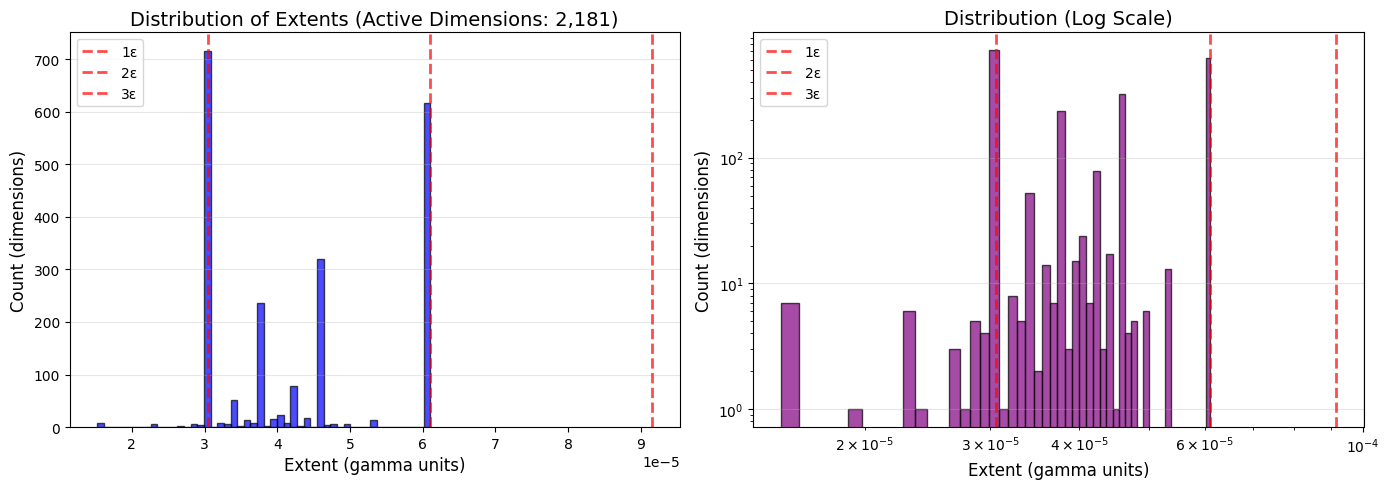

✓ Distribution plotted


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

ranges_np = dim_range.cpu().numpy()
active_ranges_np = active_ranges.cpu().numpy()

# Panel 1: Linear scale
ax = axes[0]
ax.hist(active_ranges_np, bins=50, alpha=0.7, color='blue', edgecolor='black')

# Mark ε gridlines
for i in range(1, 4):
    ax.axvline(i * epsilon, color='red', linestyle='--', linewidth=2, alpha=0.7,
               label=f'{i}ε')

ax.set_xlabel('Extent (gamma units)', fontsize=12)
ax.set_ylabel('Count (dimensions)', fontsize=12)
ax.set_title(f'Distribution of Extents (Active Dimensions: {len(active_ranges_np):,})', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Panel 2: Log scale
ax = axes[1]
# Filter out zeros for log scale
nonzero_ranges = active_ranges_np[active_ranges_np > 1e-10]
ax.hist(nonzero_ranges, bins=50, alpha=0.7, color='purple', edgecolor='black')

# Mark ε gridlines
for i in range(1, 4):
    ax.axvline(i * epsilon, color='red', linestyle='--', linewidth=2, alpha=0.7,
               label=f'{i}ε')

ax.set_xlabel('Extent (gamma units)', fontsize=12)
ax.set_ylabel('Count (dimensions)', fontsize=12)
ax.set_title('Distribution (Log Scale)', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Distribution plotted")

## Visualization 3: Extent vs Dimension Index

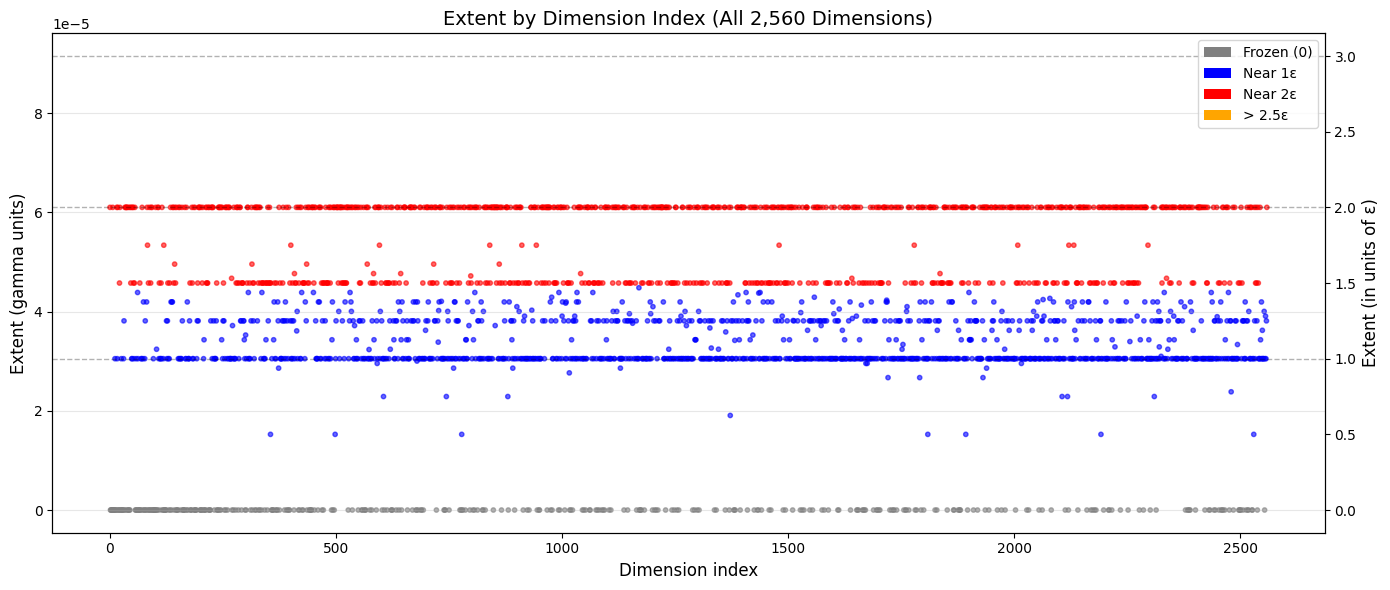

✓ Dimension scatter plotted


In [9]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)

# Scatter plot: dimension index vs extent
dims = np.arange(d)
ranges_np = dim_range.cpu().numpy()

# Color by category
colors = np.where(is_frozen.cpu().numpy(), 'gray',
         np.where(ranges_np < 1.5 * epsilon, 'blue',
         np.where(ranges_np < 2.5 * epsilon, 'red', 'orange')))

ax.scatter(dims, ranges_np, c=colors, s=10, alpha=0.6)

# Mark ε gridlines
for i in range(1, 4):
    ax.axhline(i * epsilon, color='black', linestyle='--', linewidth=1, alpha=0.3,
               label=f'{i}ε')

ax.set_xlabel('Dimension index', fontsize=12)
ax.set_ylabel('Extent (gamma units)', fontsize=12)
ax.set_title(f'Extent by Dimension Index (All {d:,} Dimensions)', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Add secondary y-axis
ax2 = ax.twinx()
ax2.set_ylim([y / epsilon for y in ax.get_ylim()])
ax2.set_ylabel('Extent (in units of ε)', fontsize=12)

# Legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='gray', label='Frozen (0)'),
    Patch(facecolor='blue', label='Near 1ε'),
    Patch(facecolor='red', label='Near 2ε'),
    Patch(facecolor='orange', label='> 2.5ε')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print("✓ Dimension scatter plotted")

## Detailed Breakdown Table

In [10]:
print("="*80)
print("DETAILED EXTENT BREAKDOWN")
print("="*80)
print()
print("Category        | Count      | Fraction | Range (gamma)        | Range (ε units)")
print("-" * 85)

categories = [
    ("Frozen (0)", is_frozen, None, None),
    ("Near 1ε", (dim_range >= 0.5 * epsilon) & (dim_range < 1.5 * epsilon), 0.5 * epsilon, 1.5 * epsilon),
    ("Near 2ε", (dim_range >= 1.5 * epsilon) & (dim_range < 2.5 * epsilon), 1.5 * epsilon, 2.5 * epsilon),
    ("Larger", dim_range >= 2.5 * epsilon, 2.5 * epsilon, None)
]

for name, mask, lower, upper in categories:
    count = mask.sum().item()
    fraction = 100 * count / d
    
    if count > 0:
        subset = dim_range[mask]
        range_str = f"[{subset.min().item():.2e}, {subset.max().item():.2e}]"
        eps_str = f"[{subset.min().item()/epsilon:.2f}, {subset.max().item()/epsilon:.2f}]ε"
    else:
        range_str = "—"
        eps_str = "—"
    
    print(f"{name:15s} | {count:10,} | {fraction:6.1f}% | {range_str:20s} | {eps_str}")

print()
print("="*80)

DETAILED EXTENT BREAKDOWN

Category        | Count      | Fraction | Range (gamma)        | Range (ε units)
-------------------------------------------------------------------------------------
Frozen (0)      |        379 |   14.8% | [0.00e+00, 0.00e+00] | [0.00, 0.00]ε
Near 1ε         |      1,216 |   47.5% | [1.53e-05, 4.48e-05] | [0.50, 1.47]ε
Near 2ε         |        965 |   37.7% | [4.58e-05, 6.10e-05] | [1.50, 2.00]ε
Larger          |          0 |    0.0% | —                    | —



## Summary

In [11]:
print("="*80)
print("HYPERCUBE EXTENT SUMMARY")
print("="*80)
print()
print(f"Crystal: {n_vectors:,} vectors in {d:,}-dimensional space")
print()
print(f"Reference scale: ε = {epsilon:.6e} gamma units")
print()
print("Extent statistics (active dimensions):")
print(f"  Maximum extent:  {active_ranges.max().item():.6e} = {active_ranges.max().item()/epsilon:.2f}ε")
print(f"  Median extent:   {active_ranges.median().item():.6e} = {active_ranges.median().item()/epsilon:.2f}ε")
print(f"  Minimum extent:  {active_ranges.min().item():.6e} = {active_ranges.min().item()/epsilon:.2f}ε")
print()
print("Hypercube profile:")
print(f"  {n_frozen:,} dimensions: frozen (extent = 0)")
print(f"  {n_near_epsilon:,} dimensions: ~1ε wide (binary, 2 lattice sites)")
print(f"  {n_near_2epsilon:,} dimensions: ~2ε wide (ternary, 3 lattice sites)")
print(f"  {n_larger:,} dimensions: > 2.5ε wide (more complex)")
print()
print("="*80)

HYPERCUBE EXTENT SUMMARY

Crystal: 124 vectors in 2,560-dimensional space

Reference scale: ε = 3.051758e-05 gamma units

Extent statistics (active dimensions):
  Maximum extent:  6.103539e-05 = 2.00ε
  Median extent:   4.005432e-05 = 1.31ε
  Minimum extent:  1.525879e-05 = 0.50ε

Hypercube profile:
  379 dimensions: frozen (extent = 0)
  1,216 dimensions: ~1ε wide (binary, 2 lattice sites)
  965 dimensions: ~2ε wide (ternary, 3 lattice sites)
  0 dimensions: > 2.5ε wide (more complex)



## Conclusion

**What we visualized:**
- Extent in each dimension (gamma units with ε reference)
- Sorted profile showing the "shape" of the hypercube
- Distribution with clear ε markers
- Breakdown by width category

**Key findings:**
- Maximum extent: ~2ε in any dimension
- Most dimensions: 0ε (frozen), 1ε (binary), or 2ε (ternary)
- The hypercube is tiny: ≤ 2 cells wide in every direction

**Interpretation:**

The black hole cluster is a **2,181-dimensional hypercube** where:
- Each dimension spans at most 2 cells (3 lattice sites)
- Total bounding box: 1×1×...×1×2×2×...×2 cells
- Only 124 of ~10^700 possible lattice sites are occupied
- It's a **sparse crystal** — almost all sites vacant

**Next steps:**
- 10.2a: Coordination numbers (how many neighbors per site?)
- 10.2b: Vacancy analysis (which lattice sites are empty?)
- 10.2c: Cleavage planes (dimensions with perfect binary split)